# QDA + Pseudo Labeling + Gaussian Mixture = LB 0.975
The dataset for Kaggle competition "Instant Gratification" appears to be 512 datasets concatenated where each sub dataset is believed to be created by Sklearn's `make_classification`. EDA suggests the following parameters:
  
    X, y = make_classification(n_samples=1024, n_features=255, n_informative=33+x,
                n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=3,
                weights=None, flip_y=0.05, class_sep=1.0, hypercube=True, shift=0.0, 
                scale=1.0, shuffle=True, random_state=None) # where 0<=x<=14
                
The important parameters to note are `n_clusters_per_class=3` and `n_informative=33+x`. This means that the data resides in `33+x` dimensional space within 6 hyper-ellipsoids. Each hyper-ellipsoid is a multivariate Gaussian distribution therefore the best classifiers to use are QDA, Pseudo Labeling, and Gaussian Mixture. (See appendix for EDA showing 3 clusters per class).

![image](http://playagricola.com/Kaggle/six62019.jpg)

# Better than Perfect Classifier!
If Kaggle generated the data with the above function call to `make_classification` then

Many participants will submit a perfect classifier since the data is easy to separate using QDA and GM. Therefore to win this Kaggle competition, we must submit a better than perfect classifier! The code presented in this kernel has randomness added (and marked in the code below) which allows this classifier to score as much as LB 0.00050 better than a perfect classifier.

If the data is made with Sklearn's `make_classification`, perfect classification is classifying everything correctly except the 2.5% randomly flipped labels. No model can consistently predict the flipped labels correct. However, if you add randomness to your model sometimes it will do better than perfect (and get some flipped targets correct) and sometimes it will do worse. Below is a scatter plot of this kernel's performance. The dotted line is a perfect classifier and each dot is one attempt of this kernel to classify a synthetic dataset (that is similar to this comp's data). 

The 200 dots represent 10 attempts made on each of 20 different randomly created synthetic datasets. The black dotted lines were determined by modifying `make_classification` to output the AUC of perfect classification. (See Appendix 3 for more info).


![image](http://playagricola.com/Kaggle/scatter61719.png)

This scatter plot also shows that there is no correlation between this kernel's public LB and private LB performance. Therefore for our final submission, we will not choose our highest public LB submission. We will run this kernel 30 times and submit two versions chosen at random regardless of their public LB performance. Then we cross our fingers and hope that those two runs score better than perfect private test dataset classification :P


In [1]:
import numpy as np
np.random.seed(42)
x = np.random.choice(np.arange(30),2)
print('We will submit versions',x[0],'and',x[1])
np.random.seed(None)

We will submit versions 6 and 19


## UPDATE: How Lucky Were We?
After the competition ended, I made the plot below showing this kernel's 30 public and private LB scores. The two randomly chosen final submissions are versions 6 and 19 colored green below. The highest **public** LB is 0.97481 achieved by version 25. The lowest public LB is 0.97439 by version 7. The highest **private** LB is 0.97588 by version 19. The lowest private LB is 0.97543 by version 23.

The black dotted lines represent this kernel's public and private prediction averages. (For more info about this plot and the above plot, see Appendix 3).

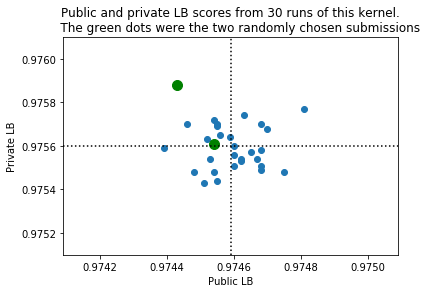

In [2]:
import matplotlib.pyplot as plt, numpy as np
pu = np.array([68,53,70,67,54,54,39,68,60,65,46,62,62,55,54,
               60,59,55,43,52,63,68,51,75,81,56,68,55,60,48])
pr = np.array([58,54,68,54,48,61,59,49,60,57,70,54,53,69,72,
               56,64,44,88,63,74,70,43,48,77,65,51,70,51,48])
plt.scatter(0.974+pu/1e5,0.975+pr/1e5)
plt.scatter(0.974+pu[5]/1e5,0.975+pr[5]/1e5,color='green',s=100)
plt.scatter(0.974+pu[18]/1e5,0.975+pr[18]/1e5,color='green',s=100)

mpu = 0.974 + np.mean(pu)/1e5
mpr = 0.975 + np.mean(pr)/1e5
plt.plot([mpu,mpu],[mpr-0.0005,mpr+0.0005],':k')
plt.plot([mpu-0.0005,mpu+0.0005],[mpr,mpr],':k')

plt.xlabel('Public LB'); plt.xlim((mpu-0.0005,mpu+0.0005))
plt.ylabel('Private LB'); plt.ylim((mpr-0.0005,mpr+0.0005))
plt.title("Public and private LB scores from 30 runs of this kernel.\n \
    The green dots were the two randomly chosen submissions")
plt.show()

# Load Libraries and Data

In [3]:
# IMPORT LIBRARIES
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [4]:
# LOAD TRAIN AND TEST
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Identify Useful Features
Sklearn's `make_classification` leaks which features are useful by increasing their variance.

In [5]:
# IDENTIFY USEFUL FEATURES PER MAGIC SUB-DATASET
useful = np.zeros((256,512))
for i in range(512):
    partial = df_train[ df_train['wheezy-copper-turtle-magic']==i ]
    useful[:,i] = np.std(partial.iloc[:,1:-1], axis=0)
useful = useful > 1.5
useful = np.sum( useful, axis=0 )

# Model and Predict
Our model is as follows. First we use QDA plus Pseudo Labeling to predict `test.csv` with CV 0.970 accuracy as previously done [here][1]. Next we will use these predictions (pseudo labels) to find the 6 ellipses. We separately find the 3 ellipses of the target=1 data and 3 ellipses of the target=0 data using Sklearn GaussianMixture. Then we label each point with 0, 1, 2, 3, 4, 5 representing which ellipse it belongs to. Finally we train QDA on these 6 ellipses and use QDA to make our final predictions with `Pr(target=1) = Pr(in ellipse 3) + Pr(in ellipse 4) + Pr(in ellipse 5)`. (See appendix 2 for advanced techniques).

For validation, we didn't use typical k-folds CV. Instead we created synthetic data and optimized our technique on synthetic data. This has proven to be more reliable than CV. Also it allows our model to use all 1024 rows of sub datasets when building models. Our model has demonstrated that on average it can perfectly classify Sklearn's `make_classification` data. However many other participants can too. So randomness is added which allows us to do better than perfect sometimes. Then two random versions' output were submitted to Kaggle and hopefully those are the high scoring ones! :P

When the code below is run locally, it generates synthetic data and calculates validation AUC. When the code is submitted to Kaggle, it uses real data and predicts `test.csv`.

[1]: https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969

In [6]:
# RUN LOCALLY AND VALIDATE
models = 512
RunLocally = True

# RUN SUBMITTED TO KAGGLE
if len(df_test)>512*300: 
    repeat = 1
    models = 512 * repeat
    RunLocally = False
    
# INITIALIZE
all_preds = np.zeros(len(df_test))
all_y_pu = np.array([])
all_y_pr = np.array([])
all_preds_pu = np.array([])
all_preds_pr = np.array([])

# MODEL AND PREDICT
for k in range(models):
    
    # IF RUN LOCALLY AND VALIDATE
    # THEN USE SYNTHETIC DATA
    if RunLocally:
        obs = 512
        X, y = make_classification(n_samples=1024, n_features=useful[k%512], 
                    n_informative=useful[k%512], n_redundant=0, n_repeated=0,
                    n_classes=2, n_clusters_per_class=3, weights=None, flip_y=0.05,
                    class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True,
                    random_state=None)
        
    # IF RUN SUBMITTED TO KAGGLE
    # THEN USE REAL DATA
    else:
        df_train2 = df_train[df_train['wheezy-copper-turtle-magic']==k%512]
        df_test2 = df_test[df_test['wheezy-copper-turtle-magic']==k%512]
        sel = VarianceThreshold(1.5).fit(df_train2.iloc[:,1:-1])
        df_train3 = sel.transform(df_train2.iloc[:,1:-1])
        df_test3 = sel.transform(df_test2.iloc[:,1:])
        obs = df_train3.shape[0]
        X = np.concatenate((df_train3,df_test3),axis=0)
        y = np.concatenate((df_train2['target'].values,np.zeros(len(df_test2))))
    
    # TRAIN AND TEST DATA
    train = X[:obs,:]
    train_y = y[:obs]
    test = X[obs:,:]
    test_y = y[obs:]
    comb = X
                
    # FIRST MODEL : QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.5,0.5])
    clf.fit(train,train_y)
    test_pred = clf.predict_proba(test)[:,1]
    
    # SECOND MODEL : PSEUDO LABEL + QDA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred)) #randomness
    clf = QuadraticDiscriminantAnalysis(priors = [0.5, 0.5])
    clf.fit(comb, np.concatenate((train_y,test_pred)) )
    test_pred = clf.predict_proba(test)[:,1]
   
    # THIRD MODEL : PSEUDO LABEL + GAUSSIAN MIXTURE
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred)) #randomness
    all_y = np.concatenate((train_y,test_pred))
    least = 0; ct = 1; thx=150
    while least<thx:
        # STOPPING CRITERIA
        if ct>=10: thx -= 10
        else: thx = 150
        # FIND CLUSTERS
        clusters = np.zeros((len(comb),6))
        # FIND THREE TARGET=1 CLUSTERS
        train4 = comb[ np.argwhere(all_y==1).flatten(), :]
        clf = GaussianMixture(n_components=3).fit(train4) #randomness
        clusters[ np.argwhere(all_y==1).flatten(), 3:] = clf.predict_proba(train4)
        # FIND THREE TARGET=0 CLUSTERS
        train4 = comb[ np.argwhere(all_y==0).flatten(), :]
        clf = GaussianMixture(n_components=3).fit(train4) #randomness
        clusters[ np.argwhere(all_y==0).flatten(), :3] = clf.predict_proba(train4)
        # SMOOTH LABELS
        for j in range(5): clusters[:,j+1] += clusters[:,j]
        rand = np.random.uniform(0,1,clusters.shape[0])
        for j in range(6): clusters[:,j] = clusters[:,j]>rand #randomness
        clusters2 = 6 - np.sum(clusters,axis=1)
        # IF IMBALANCED TRY AGAIN
        least = pd.Series(clusters2).value_counts().min(); ct += 1

    # FOURTH MODEL : GAUSSIAN MIXTURE + QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167])
    clf.fit(comb,clusters2)
    pds = clf.predict_proba(test)
    test_pred = pds[:,3]+pds[:,4]+pds[:,5]
        
    # IF RUN LOCALLY, STORE TARGETS AND PREDS
    if RunLocally:
        all_y_pu = np.append(all_y_pu, test_y[:256])
        all_y_pr = np.append(all_y_pr, test_y[256:])
        all_preds_pu = np.append(all_preds_pu, test_pred[:256])
        all_preds_pr = np.append(all_preds_pr, test_pred[256:])
    # IF RUN SUBMIT TO KAGGLE, PREDICT TEST.CSV
    else:
        all_preds[df_test2.index] += test_pred / repeat
        
    # PRINT PROGRESS
    if ((k+1)%64==0)|(k==0): print('modeled and predicted',k+1,'magic sub datasets')

# IF RUN LOCALLY, COMPUTE AND PRINT VALIDATION AUCS
if RunLocally: 
    all_y_pu_pr = np.concatenate((all_y_pu,all_y_pr))
    all_preds_pu_pr = np.concatenate((all_preds_pu,all_preds_pr))
    auc1 = roc_auc_score(all_y_pu_pr, all_preds_pu_pr)
    auc2 = roc_auc_score(all_y_pu, all_preds_pu)
    auc3 = roc_auc_score(all_y_pr, all_preds_pr)
    print()
    print('Validation AUC =',np.round(auc1,5))
    print('Approx Public LB =',np.round(auc2,5))
    print('Approx Private LB =',np.round(auc3,5))

modeled and predicted 1 magic sub datasets
modeled and predicted 64 magic sub datasets
modeled and predicted 128 magic sub datasets
modeled and predicted 192 magic sub datasets
modeled and predicted 256 magic sub datasets
modeled and predicted 320 magic sub datasets
modeled and predicted 384 magic sub datasets
modeled and predicted 448 magic sub datasets
modeled and predicted 512 magic sub datasets

Validation AUC = 0.97515
Approx Public LB = 0.9755
Approx Private LB = 0.9748


# Submit to Kaggle
Alright, let's cross our fingers and hope that our submission has a high private LB !!

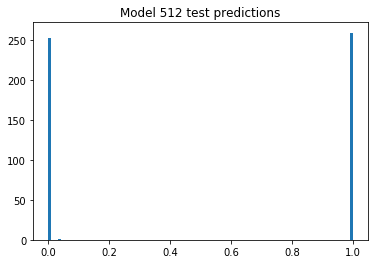

In [7]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = all_preds
sub.to_csv('submission.csv',index=False)

plt.hist( test_pred ,bins=100)
plt.title('Model 512 test predictions')
plt.show()

# Appendix 1 - EDA revealing n_clusters_per_class = 3
We believe the data was made from Sklearn's `make_classification`. An important question is what parameter for `n_clusters_per_class` did Kaggle use? 

According to Sklearn's documentation [here][1]:

> This initially creates clusters of points normally distributed (std=1) about vertices of an n-informative-dimensional hypercube with sides of length 2 * class_sep and assigns an equal number of clusters to each class.

In three dimensions that means, that the clusters will be centered at one of these 8 locations: (-1, -1, -1), (-1, -1, 1), (-1, 1, -1), (-1, 1, 1), (1, -1, -1), (1, -1, 1), (1, 1, -1), (1, 1, 1) where you replace all 1's by `class_sep`. If you create 1024 rows of data and have 2 clusters per class, then for `target=1`, you may have 256 points centered at (-1, 1, -1) and 256 points centered at (1, 1, -1). Then for `target=0`, you may have 256 points centered at (1, 1, 1) and 256 points centered at (-1, -1, 1).

Using EDA, we can determine the number of clusters per class of the real data. Sklearn's `make_classification` generates data (ellipses) at hypercube corners. Therefore if there is only `n_clusters_per_class=1` then the center of each ellipse (target=1 and target=0) of data will have all coordinates 1's and -1's, for example (1,1,-1,1,-1,1,...). So if we plot a histogram of all the variables' means (center coordinates), we will see a bump at 1 and -1. (By variable we mean within each sub dataset. That's 768 rows of train and public test. We don't mean all 262144 rows of original train columns).

If `n_clusters_per_class=2`, then within one sub dataset there will be 2 ellipses for target=1. For example, there may be one ellipse centered at (-1,1,...) and one at (1,1,...) and the first coordinates of 1 and -1 will average to 0 when we compute that variable's mean. Therefore, if `clusters=2`, we will see histogram bumps at -1, 0, and 1. If `n_clusters_per_class=3`, we will see 4 bumps. Etc, etc. We can confirm this with synthetic data. We will use `n_samples=768` because we only have training and public test data to compare with which only has 768 rows per `wheezy-magic` sub dataset.

Afterward, we will plot a histogram of the real data's variable means (within sub datasets) and see which `n_clusters_per_class` it matches. Alternatively, we can build a model and assume that `n_clusters_per_class` equals 1, 2, 3, or 4. Then we check which `n_clusters_per_class` has the greatest CV. Both of these methods determine that `n_clusters_per_class=3`.

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

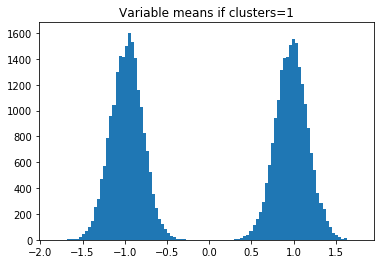

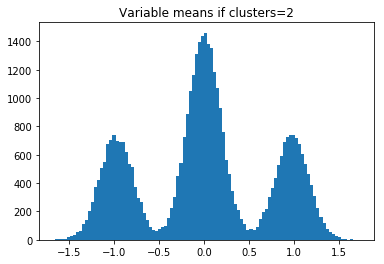

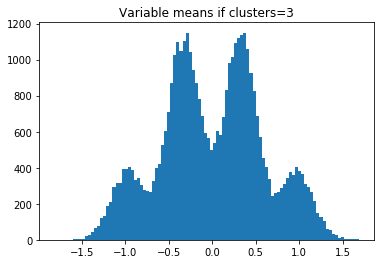

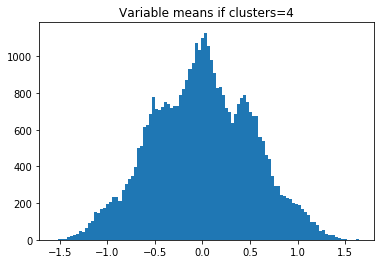

In [8]:
for clusters in range(4):
    centers = np.array([])
    for k in range(512):
        X, y = make_classification(n_samples=768, n_features=useful[k], 
                    n_informative=useful[k], n_redundant=0, n_repeated=0, 
                    n_classes=2, n_clusters_per_class=clusters+1, weights=None, 
                    flip_y=0.05, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                    shuffle=True, random_state=None)
        centers = np.append(centers,np.mean(X[ np.argwhere(y==0).flatten() ,:],axis=0))
        centers = np.append(centers,np.mean(X[ np.argwhere(y==1).flatten() ,:],axis=0))
    plt.hist(centers,bins=100)
    plt.title('Variable means if clusters='+str(clusters+1))
    plt.show()


## Now let's plot the real data
First we will use QDA to create pseudo labels for the public test data. Then we will plot a histogram of the variable means (data centers' coordinates) of target=0 and target=1 using all training and pseudo labeled public test data combined (768 rows per sub dataset). The plot below shows that Kaggle used `n_clusters_per_class=3`.

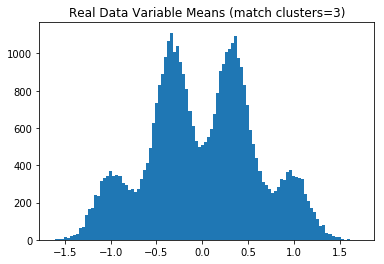

In [9]:
centers = np.array([])
for k in range(512):
    
    # REAL DATA
    df_train2 = df_train[df_train['wheezy-copper-turtle-magic']==k]
    df_test2 = df_test[df_test['wheezy-copper-turtle-magic']==k]
    sel = VarianceThreshold(1.5).fit(df_train2.iloc[:,1:-1])
    df_train3 = sel.transform(df_train2.iloc[:,1:-1])
    df_test3 = sel.transform(df_test2.iloc[:,1:])
    obs = df_train3.shape[0]
    X = np.concatenate((df_train3,df_test3),axis=0)
    y = np.concatenate((df_train2['target'].values,np.zeros(len(df_test2))))
    
    # TRAIN AND TEST DATA
    train = X[:obs,:]
    train_y = y[:obs]
    test = X[obs:,:]
    test_y = y[obs:]
    comb = X
                
    # FIRST MODEL : QDA
    clf = QuadraticDiscriminantAnalysis(priors = [0.5,0.5])
    clf.fit(train,train_y)
    test_pred = clf.predict_proba(test)[:,1]
    
    # SECOND MODEL : PSEUDO LABEL + QDA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred))
    clf = QuadraticDiscriminantAnalysis(priors = [0.5, 0.5])
    clf.fit(comb, np.concatenate((train_y,test_pred)) )
    test_pred = clf.predict_proba(test)[:,1]
    
    # PSEUDO LABEL TEST DATA
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred))
    y[obs:] = test_pred
    
    # COLLECT CENTER COORDINATES
    centers = np.append(centers,np.mean(X[ np.argwhere(y==0).flatten() ,:],axis=0))
    centers = np.append(centers,np.mean(X[ np.argwhere(y==1).flatten() ,:],axis=0))
    
# PLOT CENTER COORDINATES
plt.hist(centers,bins=100)
plt.title('Real Data Variable Means (match clusters=3)')
plt.show()

# Appendix 2 - Advanced Techniques
Since the code above already classifies Sklearn's `make_classification` on average prefectly, there is no need to improve it. However, below are some ideas that could be used if improvement was possible and/or neccessary.

1. After building model 4's classifier, you could use it to classify the training data. Then all training data with `abs(oof - true)>0.9` are erroneous training data with their labels flippped. Next correct those training labels and run the entire kernel a second time.

2. Since each cluster is centered at a hypercube corner, you can modify Sklearn's Quadratic Discriminant Analysis code by adding `meang[ np.argwhere(meang>=0) ] = 1.0` and `meang[ np.argwhere(meang<0) ] = -1.0`. This moves the centers of all clusters to hypercube corners.

3. Computer accuracy cannot distinguish between predictions that are close to 1. Using an example with 6 digit accuracy, the numbers 1.000001 and 1.000002 are the same because both become 1.00000. To help improve AUC, you can add the following code to this kernel. `temp = np.log(pds[:,0]+pds[:,1]+pds[:,2])`; `temp[ np.isinf(temp) ] = -1e6`; `test_pred -= temp`. This improves AUC by differentiating between predictions close to 1. Note that this isn't a problem for predictions close to 0 because the numbers 0.0000001 and 0.0000002 are 1.0e-7 and 2.0e-7 and the computer can already differentiate them.

4. After making predictions for `test.csv`, you can use them as pseudo labels and run the entire kernel a second time. Then use those labels and run the kernel a third time. Each iteration can give a slight boost.

5. You can run this kernel multiple times and take an average. Or use k-folds. This removes this code's variance (randomness) and achieves close to prefection everytime but it also removes the possibility of scoring LB 0.00050 more or less than perfection.

6. We can also remove this code's variance (randomness) by modifying Sklearn's code for Quadratic Discriminant Analysis and Gaussian Mixture. Each of these models can only accept training labels that are either 0 or 1. By adding a few lines of code, we can allow these models to accept continuous probabilities and use them as weights. This would allow us to remove the randomization line `test_pred = test_pred > np.random.uniform(0,1,len(test_pred))`. Instead we can leave pseudo labels as probabilities between 0 and 1 and still call `QuadraticDiscriminantAnalysis.fit(test_data,test_pred)`.

Using combinations of these additional advanced techniques, this kernel was able to score LB 0.97489 on this competition's public leaderboard. But validation showed that these techniques didn't make the basic perfect classifier any more perfect. Therefore for final submission, the basic classifier was used.

# Appendix 3 - Final Submission Strategy
By applying our model to synthetic data, we can learn how it performs on a simulated public and private leaderboard. We observe that this kernel achieves perfection on average (if Kaggle used `make_classification` with the parameters we suspect). Sklearn's code for `make_classification` includes

        # Randomly replace labels
        if flip_y >= 0.0:
            flip_mask = generator.rand(n_samples) < flip_y
            y[flip_mask] = generator.randint(n_classes, size=flip_mask.sum())
            
Before variable `y` gets rewritten, you can store it by adding `y_orig = y.copy()`. Next update the shuffle line to `X, y, y_orig = util_shuffle(X, y, y_orig, random_state=generator)`. Then change the last line of `make_classification` to `return X, y, y_orig`. By doing this, we can compute the AUC of a perfect classifier with `prefect = roc_auc_score(y, y_orig)`.
 
Now we can make hundreds of synthetic datasets that are the similar to this competition's data and apply this kernel to see how well it does compared with a perfect classifier. For each synthetic dataset, we will run this kernel 10 times. This will show us patterns and help us decide how to choose our two final submissions. 
 
We observe that sometimes this kenel does better than perfect and sometimes it does worse than perfect. It's interesting to note that there is no correlation between its performance on public LB versus private LB. In the example plots below, perfect classification is represented by the black dotted line.

If we take the average of this kernel's performance over many sythnetic datasets, it achieves perfect classification. Therefore there is no reason to improve this kernel. We can never expect to perform better than perfect classification on average. The only change we could consider is altering this kernel's standard deviation from perfection. We could either try to achieve perfection every kernel run, or (leave it as is and) randomly try to exceed perfection by a desired amount on some kernel runs.
 
## Synthetic Dataset 1
![image](http://playagricola.com/Kaggle/ex161919.png)
## Synthetic Dataset 2
![image](http://playagricola.com/Kaggle/ex261919.png)
## Synthetic Dataset 3
![image](http://playagricola.com/Kaggle/ex361919.png)
## Synthetic Dataset 4
![image](http://playagricola.com/Kaggle/ex461919.png)
## Synthetic Dataset 5
![image](http://playagricola.com/Kaggle/ex561919.png)
## Many Synthetic Datasets Together
![image](http://playagricola.com/Kaggle/scatter61719.png)